In [77]:
!pip install --quiet wikipedia==1.4.0 langchain-core==0.3.59 langgraph==0.5.3 langchain-openai==0.3.16 langchain-experimental==0.3.4 pydantic==2.11.9 python-dotenv==1.0.1 requests==2.31.0
!pip install rapidfuzz
!pip install tabulate

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-classic 1.0.1 requires langchain-core<2.0.0,>=1.2.5, but you have langchain-core 0.3.59 which is incompatible.
langchain-classic 1.0.1 requires langchain-text-splitters<2.0.0,>=1.1.0, but you have langchain-text-splitters 0.3.8 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [78]:
!pip install --quiet langchain-core==0.3.69 langgraph==0.5.3 langchain-openai==0.3.28 langchain-experimental==0.3.4 langgraph-supervisor==0.0.27 pydantic==2.11.9

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-classic 1.0.1 requires langchain-core<2.0.0,>=1.2.5, but you have langchain-core 0.3.69 which is incompatible.
langchain-classic 1.0.1 requires langchain-text-splitters<2.0.0,>=1.1.0, but you have langchain-text-splitters 0.3.8 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [79]:
import requests
import json

base_url = 'https://fantasy.premierleague.com/api/'

bootstrap_url = base_url + 'bootstrap-static'

data = json.loads(requests.get(bootstrap_url).text)


In [ ]:
from typing import Annotated
from langchain_core.tools import tool
import pandas as pd
import os
from dotenv import load_dotenv

## Helper Functions
def get_player_name_from_id(player_id: Annotated[int, "The ID of the English Premier League Player whose name you want to look up."]) -> str:
    """
    Use this to look-up the name of a player in the English Premier League (EPL) given their player ID.
    """
    player_data = data['elements']
    df = pd.DataFrame(player_data)
    player_info = df[df['id'] == player_id]
    if player_info.empty:
        return f"No data found for player ID: {player_id}"
    player_name = f"{player_info.iloc[0]['first_name']} {player_info.iloc[0]['second_name']}"
    return player_name

def get_team_name_from_id(team_id: Annotated[int, "The ID of the English Premier League Team whose name you want to look up."]) -> str:
    """
    Use this to look-up the name of a team in the English Premier League (EPL) given their team ID.
    """
    team_data = data['teams']
    df = pd.DataFrame(team_data)
    team_info = df[df['id'] == team_id]
    if team_info.empty:
        return f"No data found for team ID: {team_id}"
    team_name = team_info.iloc[0]['name']
    return team_name

## TOOLS

@tool
def team_data(team_id: Annotated[str, "The unique Idenfier for the Premier League Team"]) -> str:
    """
    Use this to look-up latest football team-level performance data for teams in the English Premier League (EPL).

    If team_id = -1, then data for all teams in the EPL will be returned. Otherwise, data for the specific team corresponding to the team_id will be returned.

    The fields strength_overall_home, strength_overall_away, strength_attack_home, strength_attack_away,
    strength_defence_home, and strength_defence_away are all ratings between 1000 and 1400 that indicate how strong a team is in those areas.
    1000 is the worst possible rating and 1400 is the best possible rating.
    """
    team_data = data['teams']
    df = pd.DataFrame(team_data)
    df = df.drop(columns=['code', 'draw', 'form', 'loss', 'played', 'points', 'strength', 'team_division', 'unavailable', 'win'])
    df = df.rename(columns={'id': 'team_id'})
    
    if team_id == -1:
        return df.to_markdown()
    team_info = df[df['team_id'] == team_id]
    if team_info.empty:
        return f"No data found for team ID: {team_id}"
    return team_info.to_markdown()
    
@tool
def fpl_scoring_rules(pos: Annotated[str, 'The 3 letter code for the position of the player in FPL. Must be one of the following: GKP, DEF, MID, FWD']) -> str:
    """
    Use this to look-up the scoring rules for the English Premier League (EPL) fantasy football game.
    long_play: player played 60 or more minutes
    short_play: player played less than 60 minutes
    """
    scoring_data = data['game_config']['scoring']
    for rule in scoring_data.keys():
        if type(scoring_data[rule]) == dict:
            scoring_data[rule] = scoring_data[rule][pos]
    df = pd.DataFrame([scoring_data])
    df = df.drop(columns=['bps', 'bonus', 'influence', 'creativity', 'threat', 'ict_index', 'tackles', 
                       'clearances_blocks_interceptions', 'recoveries', 'saves', 'expected_goals_conceded', 
                       'expected_goal_involvements', 'mng_clean_sheets', 'mng_underdog_win', 'mng_underdog_draw',
                       'mng_win', 'mng_draw', 'mng_loss', 'mng_goals_scored', 'expected_goals', 'expected_assists',
                       'starts', 'special_multiplier'
                       ])
    return df.to_markdown()

@tool
def player_types() -> str:
    """
    Use this to look-up the different player types/positions in the English Premier League (EPL) fantasy football game.

    Outputs:
    position_code: The 3 letter code for the position of the player in FPL. Must be one of the following: GKP, DEF, MID, FWD
    squad_select: The number of players that can be selected in this position for the FPL squad
    squad_min_select: The minimum number of players that must be selected in this position for the FPL squad
    squad_max_select: The maximum number of players that can be selected in this position for the FPL squad
    squad_min_play: The minimum number of players that must be selected in this position for the FPL starting lineup
    squad_max_play: The maximum number of players that can be selected in this position for the
    sub_positions_locked: The positions that are locked as substitutes when a player of this position is selected in the starting lineup
    element_count: The total number of players in this position in the FPL game
    """
    element_types_data = data['element_types']
    df = pd.DataFrame(element_types_data)
    df['squad_min_select'] = [1, 3, 3, 1]
    df['squad_max_select'] = [2, 5, 5, 3]
    df = df.drop(columns=['id', 'plural_name', 'plural_name_short', 'singular_name', 
                          'ui_shirt_specific'])
    df = df.rename(columns={'singular_name_short': 'position_code'})
    return df

## General GW Tools
def fixture_info_for_gw(gw: Annotated[int, "The fpl gameweek number to look up match information for."]) -> str:
    """
    Use this to look-up latest match information for a specific gameweek in the English Premier League (EPL).
    The function outputs a markdown table containing details about each fixture in the specified gameweek.

    For each fixture, the following information is provided:
    code: Unique identifier for the fixture
    event: Gameweek number
    finished: Boolean indicating if the match has finished
    finished_provisional: Boolean indicating if the match is provisionally finished
    fixture_id: Unique ID for the fixture
    kickoff_time: Scheduled kickoff time of the match
    minutes: Minutes played in the match
    provisional_start_time: Boolean indicating if the start time is provisional
    team_a: team_id of the away team
    team_a_score: Score of the away team
    team_h: team_id of the home team
    team_h_score: Score of the home team
    stats: List of statistics for the match if the match has been played
    team_h_difficulty: Difficulty rating for the home team
    team_a_difficulty: Difficulty rating for the away team
    """
    url = f'https://fantasy.premierleague.com/api/fixtures/?event={gw}'
    fixtures_data = json.loads(requests.get(url).text)
    df = pd.DataFrame(fixtures_data)
    df = df.rename(columns={'id': 'fixture_id'})
    df = df.drop(columns=['code', 'finished_provisional', 'provisional_start_time', 'stats', 'pulse_id'])
    
    df['team_a'] = df['team_a'].apply(get_team_name_from_id)
    df['team_h'] = df['team_h'].apply(get_team_name_from_id)
    
    if df.empty:
        return f"No match data found for gameweek: {gw}"
    return df.to_markdown()

@tool
def fixture_stats(fixture_id: Annotated[int, 'The Fixture id of the football match for which you want to get data from.'],
                  stat: Annotated[str, 'The specific stat that you want to look at: Has to be one of the following: goals_scored, assists, own_goals, penalties_saved, penalties_missed, yellow_cards, red_cards, saves, bonus, bps, defensive_contribution']) -> str:
    """
    Use this to look-up specific stats for a specific fixture in the English Premier League (EPL).
    The function outputs a markdown table containing the player IDs and their corresponding values for the specified stat in the given fixture. 
    The player IDs can be used to look up the names of the players using the get_player_name_from_id tool if needed.

    The player IDs are sorted in descending order based on the value of the specified stat, so that the player with the highest value for that stat in the fixture is listed at the top of the table.
    """
    
    endpoint = f'fixtures/?id={fixture_id}'


    fixture_data = json.loads(requests.get(base_url + endpoint).text)[2]
    if not fixture_data:
        return f"No data found for fixture ID: {fixture_id}"
    stats = fixture_data.get('stats', [])
    if not stats:
        return f"No stats found for fixture ID: {fixture_id}"
    df = pd.DataFrame(stats)
    if stat in df['identifier'].values:
        df = df[df['identifier'] == stat]
        if df.empty:
            return f"No data found for stat: {stat} in fixture ID: {fixture_id}"
        
        # Storing the stat values for both h and a in a separate df with columns 'value' and 'element'
        stat_values = []
        for index, row in df.iterrows():
            for home_away in ['h','a']:
                for stat_info in row[home_away]:
                    stat_values.append({
                        'element': stat_info['element'],
                        'value': stat_info['value']
                    })
        df = pd.DataFrame(stat_values)
        df = df.rename(columns={'value': stat, 'element': 'player_id'}).sort_values(by=stat, ascending=False)
    
    return df.to_markdown()

@tool
def current_gw_status() -> str:
    """
    Use this to look-up the current gameweek number and the live status of the current gameweek. 
    The output contains a list of days in YYYY-MM-DD format for which there are matches scheduled in the current gameweek. 
    
    For each day, the following information is provided:
    bonus_added: Boolean indicating if bonus points have been added for matches on that day
    date: The date of the matches in YYYY-MM-DD format
    event: Gameweek number
    
    There is also a field called 'leagues', which is either 'updating' or 'complete'. 
    If it's 'updating', it means that the current gameweek is still ongoing and match results are still being updated. 
    If it's 'complete', it means that the current gameweek has finished and all match results have been updated.
    """
    endpoint = '/event-status'
    url = base_url + endpoint
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve current gameweek status. HTTP Status Code: {response.status_code}"
    status_data = json.loads(response.text)
    df = pd.DataFrame(status_data)
    return df.to_markdown()

@tool
def fpl_gw_info(gw: Annotated[int, "The fpl gameweek number to look up information for."]) -> str:
    """
    Use this to look-up latest information about a specific gameweek in the English Premier League (EPL).
    
    Outputs:
    gameweek: The ID of the gameweek (e.g., 1, 2, 3, etc.).
    gameweek_name: The name of the gameweek (e.g., "Gameweek 1", "Gameweek 2").
    deadline_time: The deadline for making transfers, setting your team, or using chips for the gameweek. This is in ISO 8601 format (e.g., 2026-02-15T12:30:00Z).
    release_time: The time when the gameweek data (e.g., fixtures, stats) is released. This is also in ISO 8601 format.
    average_entry_score: The average score of all FPL managers for that gameweek.
    finished: A boolean (true or false) indicating whether the gameweek has concluded.
    data_checked: A boolean (true or false) indicating whether all the data for the gameweek (e.g., points, stats) has been finalized and verified.
    highest_scoring_entry: The entry ID (team ID) of the FPL manager who scored the highest points in that gameweek.
    highest_score: The highest score achieved by any FPL manager in that gameweek.
    is_previous: A boolean (true or false) indicating whether this gameweek is the one that just finished (i.e., the most recent completed gameweek).
    is_current: A boolean (true or false) indicating whether this is the current active gameweek.
    is_next: A boolean (true or false) indicating whether this is the next upcoming gameweek.
    released: A boolean (true or false) indicating whether the gameweek has been officially released (e.g., fixtures and data are available).
    ranked_count: The number of FPL managers who have been ranked in the gameweek (i.e., those who have scored points).
    most_selected: The player ID of the most selected player in FPL squads for that gameweek.
    most_transferred_in: The player ID of the most transferred-in player for that gameweek.
    highest_scoring_player_id: The player ID of the highest-scoring player in that gameweek.
    highest_scoring_player_points: The total points scored by the highest-scoring player in that gameweek.
    transfers_made: The total number of transfers made by all FPL managers during that gameweek.
    most_captained_player_id: The player ID of the most captained player in FPL squads for that gameweek.
    most_vice_captained_player_id: The player ID of the most vice-captained player in FPL squads for that gameweek.
    """
    events_data = data['events']
    df = pd.DataFrame(events_data)
    gw_info = df[df['id'] == gw]
    if gw_info.empty:
        return f"No data found for gameweek: {gw}"
    
    gw_info = gw_info.rename(columns={
        'id': 'gameweek',
        'name': 'gameweek_name',
        'top_element': 'highest_scoring_player_id',
        'top_element_info': 'highest_scoring_player_points',
        'most_captained': 'most_captained_player_id',
        'most_vice_captained': 'most_vice_captained_player_id'
    })

    gw_info['highest_scoring_player_points'] = gw_info['highest_scoring_player_points'].apply(lambda x: x['points'] if isinstance(x, dict) else None)
    
    gw_info = gw_info.drop(columns=['overrides', 'cup_leagues_created', 'h2h_ko_matches_created', 
                                     'can_enter', 'can_manage', 'chip_plays', 'deadline_time_game_offset',
                                     'deadline_time_epoch'])
    return gw_info.to_markdown()


## FPL-specific Tools
@tool
def fpl_league_standings(league_id: Annotated[int, "The ID of the FPL league to look up standings for."]) -> str:
    """
    Use this to look-up the current standings of a specific FPL league. 
    The output contains a markdown table with the following information for each team in the league:
    - gw_points: Total points scored by the team in the current gameweek
    - fpl_manager_name: Name of the FPL team manager
    - current_rank: Current rank of the team in the league
    - last_rank: The team's rank in the previous gameweek
    - fpl_total_points: Total points scored by the team in all gameweeks so far
    - fpl_team_id: Unique identifier for the FPL team
    - fpl_team_name: Name of the team
    - movement: Change in rank from the previous gameweek (positive means moved up, negative means moved down)
    """
    url = f'https://fantasy.premierleague.com/api/leagues-classic/{league_id}/standings/'
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve league standings. HTTP Status Code: {response.status_code}"
    standings_data = json.loads(response.text)
    standings_list = standings_data['standings']['results']
    df = pd.DataFrame(standings_list)
    if df.empty:
        return f"No standings data found for league ID: {league_id}"
    
    df = df.drop(columns=['id', 'rank_sort', 'has_played'])

    df = df.rename(columns = {
        'entry': 'fpl_team_id',
        'entry_name': 'fpl_team_name',
        'event_total': 'gw_points',
        'player_name': 'fpl_manager_name',
        'rank': 'current_rank',
        'total': 'total_fpl_points'
        })
    
    df['movement'] = df['last_rank'] - df['current_rank']

    return df.to_markdown()

@tool
def most_valuable_fpl_teams():
    """Use this to look-up the most valuable FPL teams in the current season.

    Outputs:
    - fpl_team_id: Unique identifier for the team
    - fpl_team_name: Name of the team
    - fpl_manager_name: Name of the team manager
    - value_with_bank: Current value of the team. Includes the bank value of the team as well. The value is in millions (e.g., a value of 1050 means the team is worth 105 million).
    - total_transfers: Total number of transfers made by the team in the season so far
    """

    url = base_url + 'stats/most-valuable-teams'
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve most valuable teams data. HTTP Status Code: {response.status_code}"
    valuable_teams_data = json.loads(response.text)
    df = pd.DataFrame(valuable_teams_data)
    if df.empty:
        return "No data found for most valuable teams."
    
    df = df.rename(columns={
        'entry': 'fpl_team_id',
        'name': 'fpl_team_name',
        'player_name': 'fpl_manager_name',
        'value': 'fpl_team_value'}
        )
    
    df['value_with_bank'] = df['value_with_bank'] / 10

    return df.to_markdown()

@tool 
def fpl_team_players(
            user_id: Annotated[int, "The user's fantasy premier league team ID to look up information for."],
            gw: Annotated[int, "FPL Gameweek number. Must be between 1 and 38. Unless specified otherwise, use the most recent gameweek that is on-going or has just ended."]) -> str:
    """
    Use this to look-up the players in a user's fantasy premier league team for a specific gameweek.
    Note: Use the current_gw_status() tool before using this tool if you're unsure about the most recent gameweek that is on-going or has just ended.

    Outputs:
    - player_id: The ID of the player in the user's FPL team.
    - squad_position: The position of the player in the user's FPL squad (1-15). 1-11 are starting lineup, 12-15 are substitutes. 12 is always the backup goalkeeper, 13 is the first outfield substitute, 14 is the second outfield substitute, and 15 is the third outfield substitute.
    - captain_multiplier: The multiplier for the player based on whether they are the captain (2), non-captain (1), or triple-captain [refers to if the Triple Captain Chip has been played] (3).
    - is_captain: Boolean indicating whether the player is the captain of the team.
    - is_vice_captain: Boolean indicating whether the player is the vice-captain of the team.
    - player_position: The position of the player in terms of their role on the field (GKP, DEF, MID, FWD).
    - player_name: The name of the player in the user's FPL team.
    """
    url = f'https://fantasy.premierleague.com/api/entry/{user_id}/event/{gw}/picks/'
    response = requests.get(url)
    team_data = json.loads(response.text)
    team_data = team_data['picks']
    df = pd.json_normalize(team_data)
    df = df.rename(columns={
        'element': 'player_id',
        'position': 'squad_position',
        'multiplier': 'captain_multiplier',
        'element_type': 'player_position'
        })
    df['player_position'] = df['player_position'].replace({
        1: 'GKP', 
        2: 'DEF', 
        3: 'MID', 
        4: 'FWD'})
    
    df['player_name'] = df['player_id'].apply(get_player_name_from_id)
    df['team_name'] = df['player_id'].apply(lambda x: get_team_name_from_id(data['elements'][x-1]['team']))

    return df.to_markdown()

@tool
def player_stats_by_fixture(player_id: Annotated[int, "The ID of the English Premier League Player whose stats you want to look up."]) -> str:
    """
    Use this to look-up the irl stats of a specific player in the English Premier League (EPL) for each fixture they have played in this season.

    Outputs:
    – player_id: The ID of the player in the English Premier League (EPL).
    – player_name: The name of the player in the English Premier League (EPL).
    – fixture_id: The ID of the fixture/match in which the player played.
    – opponent_team: The name of the opponent team that the player faced in the fixture.
    – gw: The gameweek number in which the fixture took place.
    – minutes: The number of minutes the player played in the fixture.
    – goals_scored: The number of goals scored by the player in the fixture.
    – assists: The number of assists made by the player in the fixture.
    – clean_sheets: The number of clean sheets kept by the player in the fixture (only applicable for goalkeepers and defenders).
    – goals_conceded: The number of goals conceded by the player in the fixture (only applicable for goalkeepers and defenders).
    – own_goals: The number of own goals scored by the player in the fixture.
    – penalties_saved: The number of penalties saved by the player in the fixture (only applicable for goalkeepers).
    – penalties_missed: The number of penalties missed by the player in the fixture.
    – yellow_cards: The number of yellow cards received by the player in the fixture.
    – red_cards: The number of red cards received by the player in the fixture.
    – saves: The number of saves made by the player in the fixture (only applicable for goalkeepers).
    – bonus: The number of bonus points awarded to the player for their performance in the fixture.
    – bps: The Bonus Point System score for the player in the fixture, which is a metric used in FPL to determine bonus points based on various performance factors.
    – value: The value of the player in the fixture, which is the player's price at the time of the fixture. This value is in millions (e.g., a value of 105 means the player was worth 10.5 million at the time of the fixture).
    – points: The total FPL points scored by the player for their performance in the fixture, calculated based on the various stats and the FPL scoring rules.
    """
    endpoint = f'element-summary/{player_id}/'
    url = base_url + endpoint
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve player stats. HTTP Status Code: {response.status_code}"
    player_stats_data = json.loads(response.text)
    stats = player_stats_data.get('history', [])
    stats = pd.DataFrame(stats)

    stats = stats.rename(columns={
        'fixture': 'fixture_id',
        'element': 'player_id',
        'total_points': 'points',
        'round': 'gw',
    })

    stats['value'] = stats['value'] / 10
    stats['opponent_team'] = stats['opponent_team'].apply(get_team_name_from_id)
    stats['player_name'] = stats['player_id'].apply(get_player_name_from_id)

    new_order = ['player_id', 'player_name', 'fixture_id', 'opponent_team', 'gw', 'minutes', 'goals_scored', 'assists', 
                 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed',
                 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'value', 'points']
    stats = stats[new_order]
    return stats.to_markdown()

@tool
def player_upcoming_fixtures(player_id: Annotated[int, "The ID of the English Premier League Player whose upcoming fixtures you want to look up."]) -> str:
    """
    Use this to look-up the upcoming fixtures for a specific player in the English Premier League (EPL).

    Outputs:
    - player_id: The ID of the player in the English Premier League (EPL).
    - player_name: The name of the player in the English Premier League (EPL).
    - fixture_id: The ID of the upcoming fixture/match that the player is scheduled to play in.
    – team_h: The name of the home team in the upcoming fixture.
    – team_a: The name of the away team in the upcoming fixture.
    – gw: The gameweek number in which the upcoming fixture is scheduled to take place.
    – kickoff_time: The scheduled kickoff time for the upcoming fixture in ISO 8601 format
    """
    endpoint = f'element-summary/{player_id}/'
    url = base_url + endpoint
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve player stats. HTTP Status Code: {response.status_code}"
    player_stats_data = json.loads(response.text)
    upcoming_fixtures = player_stats_data.get('fixtures', [])
    df = pd.DataFrame(upcoming_fixtures)
    if df.empty:
        return f"No upcoming fixtures found for player ID: {player_id}"
    df = df.rename(columns={
        'id': 'fixture_id',
        'event': 'gw'
    })
    df['team_h'] = df['team_h'].apply(get_team_name_from_id)
    df['team_a'] = df['team_a'].apply(get_team_name_from_id)
    df['player_id'] = player_id
    df['player_name'] = get_player_name_from_id(player_id)

    new_order = ['player_id', 'player_name', 'fixture_id', 'team_h', 'team_a', 'gw', 'kickoff_time']
    df = df[new_order]
    return df.to_markdown()


## General Tools
from langchain_experimental.utilities import PythonREPL
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

In [ ]:
def player_upcoming_fixtures(player_id: Annotated[int, "The ID of the English Premier League Player whose upcoming fixtures you want to look up."]) -> str:
    """
    Use this to look-up the upcoming fixtures for a specific player in the English Premier League (EPL).

    Outputs:
    - player_id: The ID of the player in the English Premier League (EPL).
    - player_name: The name of the player in the English Premier League (EPL).
    - fixture_id: The ID of the upcoming fixture/match that the player is scheduled to play in.
    – team_h: The name of the home team in the upcoming fixture.
    – team_a: The name of the away team in the upcoming fixture.
    – gw: The gameweek number in which the upcoming fixture is scheduled to take place.
    – kickoff_time: The scheduled kickoff time for the upcoming fixture in ISO 8601 format
    """
    endpoint = f'element-summary/{player_id}/'
    url = base_url + endpoint
    response = requests.get(url)
    if response.status_code != 200:
        return f"Failed to retrieve player stats. HTTP Status Code: {response.status_code}"
    player_stats_data = json.loads(response.text)
    upcoming_fixtures = player_stats_data.get('fixtures', [])
    df = pd.DataFrame(upcoming_fixtures)
    if df.empty:
        return f"No upcoming fixtures found for player ID: {player_id}"
    df = df.rename(columns={
        'id': 'fixture_id',
        'event': 'gw'
    })
    df['team_h'] = df['team_h'].apply(get_team_name_from_id)
    df['team_a'] = df['team_a'].apply(get_team_name_from_id)
    df['player_id'] = player_id
    df['player_name'] = get_player_name_from_id(player_id)

    new_order = ['player_id', 'player_name', 'fixture_id', 'team_h', 'team_a', 'gw', 'kickoff_time']
    df = df[new_order]
    return df.to_markdown()
player_upcoming_fixtures(1)

    

,player_id,player_name,fixture_id,team_h,team_a,gw,kickoff_time
0,1,David Raya Martín,269,Spurs,Arsenal,27,2026-02-22T16:30:00Z
1,1,David Raya Martín,271,Arsenal,Chelsea,28,2026-03-01T16:30:00Z
2,1,David Raya Martín,283,Brighton,Arsenal,29,2026-03-04T19:30:00Z
3,1,David Raya Martín,291,Arsenal,Everton,30,2026-03-15T14:00:00Z
4,1,David Raya Martín,311,Arsenal,Bournemouth,32,2026-04-11T14:00:00Z
5,1,David Raya Martín,327,Man City,Arsenal,33,2026-04-18T14:00:00Z
6,1,David Raya Martín,331,Arsenal,Newcastle,34,2026-04-25T14:00:00Z
7,1,David Raya Martín,341,Arsenal,Fulham,35,2026-05-02T14:00:00Z
8,1,David Raya Martín,360,West Ham,Arsenal,36,2026-05-09T14:00:00Z
9,1,David Raya Martín,361,Arsenal,Burnley,37,2026-05-17T14:00:00Z


In [315]:
def team_data(team_id: Annotated[str, "The unique Idenfier for the Premier League Team"]) -> str:
    """
    Use this to look-up latest football team-level performance data for teams in the English Premier League (EPL).

    If team_id = -1, then data for all teams in the EPL will be returned. Otherwise, data for the specific team corresponding to the team_id will be returned.

    The fields strength_overall_home, strength_overall_away, strength_attack_home, strength_attack_away,
    strength_defence_home, and strength_defence_away are all ratings between 1000 and 1400 that indicate how strong a team is in those areas.
    1000 is the worst possible rating and 1400 is the best possible rating.
    """
    team_data = data['teams']
    df = pd.DataFrame(team_data)
    df = df.drop(columns=['code', 'draw', 'form', 'loss', 'played', 'points', 'strength', 'team_division', 'unavailable', 'win'])
    df = df.rename(columns={'id': 'team_id'})
    
    if team_id == -1:
        return df.to_markdown()
    team_info = df[df['team_id'] == team_id]
    if team_info.empty:
        return f"No data found for team ID: {team_id}"
    return team_info.to_markdown()

team_data(2)

'|    |   team_id | name        |   position | short_name   |   strength_overall_home |   strength_overall_away |   strength_attack_home |   strength_attack_away |   strength_defence_home |   strength_defence_away |   pulse_id |\n|---:|----------:|:------------|-----------:|:-------------|------------------------:|------------------------:|-----------------------:|-----------------------:|------------------------:|------------------------:|-----------:|\n|  1 |         2 | Aston Villa |          3 | AVL          |                    1145 |                    1185 |                   1150 |                   1170 |                    1140 |                    1200 |          2 |'

In [319]:
def get_player_name_from_id(player_id: Annotated[int, "The ID of the English Premier League Player whose name you want to look up."]) -> str:
    """
    Use this to look-up the name of a player in the English Premier League (EPL) given their player ID.
    """
    player_data = data['elements']
    df = pd.DataFrame(player_data)
    player_info = df[df['id'] == player_id]
    if player_info.empty:
        return f"No data found for player ID: {player_id}"
    player_name = f"{player_info.iloc[0]['first_name']} {player_info.iloc[0]['second_name']}"
    return player_name
get_player_name_from_id(470)

'Martin Dúbravka'

In [ ]:
# data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [82]:
data['teams'][0]

{'code': 3,
 'draw': 0,
 'form': None,
 'id': 1,
 'loss': 0,
 'name': 'Arsenal',
 'played': 0,
 'points': 0,
 'position': 1,
 'short_name': 'ARS',
 'strength': 5,
 'team_division': None,
 'unavailable': False,
 'win': 0,
 'strength_overall_home': 1300,
 'strength_overall_away': 1375,
 'strength_attack_home': 1340,
 'strength_attack_away': 1400,
 'strength_defence_home': 1260,
 'strength_defence_away': 1350,
 'pulse_id': 1}

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
load_dotenv()

tools = [team_data, python_repl_tool, fpl_gw_info, fpl_scoring_rules, 
         player_types, my_fpl_team_players, get_player_name_from_id,
         fixture_info_for_gw, current_gw_status, fpl_league_standings, most_valuable_fpl_teams]

llm = ChatOpenAI(model="gpt-4o-mini", 
                 base_url='https://openrouter.ai/api/v1', 
                 openai_api_key=os.getenv('OPENAI'),
                 temperature=0.9)
        
llm_with_tools = llm.bind_tools(tools)

def llm_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [110]:
# from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent


# # Create the llm and tools nodes
# graph_builder.add_node("llm", llm_node)


# tool_node = ToolNode(tools=tools)
# graph_builder.add_node("tools", tool_node)

# # Add the edges
# graph_builder.add_edge(START, "llm")
# graph_builder.add_conditional_edges("llm", tools_condition, ['tools', END])
# graph_builder.add_edge("tools", "llm") 

# graph = graph_builder.compile()

## Creating Agents

In [ ]:
from langgraph.prebuilt import create_react_agent

# Research Agent
research_agent = create_react_agent(
    model=llm,
    tools=[
        team_data, fpl_team_players, player_stats_by_fixture,
        player_upcoming_fixtures, fixture_info_for_gw, fixture_stats,
        fpl_scoring_rules, player_types, fpl_gw_info, current_gw_status
    ],
    prompt='''
    You are the Research Agent for an FPL (Fantasy Premier League) advisory system.
    Your role is to fetch, organize, and prepare ALL raw data that downstream agents
    will need to make decisions.

    You are the DATA FOUNDATION of the system. Every other agent depends on the
    quality and completeness of the data you provide.

    INSTRUCTIONS:
    1. When called by the supervisor, gather the following data using your tools:

       a) CURRENT GAMEWEEK CONTEXT:
          - Use current_gw_status to determine the current GW number and its live status.
          - Use fpl_gw_info to get detailed info about the current and next GW
            (deadline_time, average_entry_score, most_selected, most_captained_player_id,
            most_transferred_in, highest_scoring_player_id).

       b) MY SQUAD:
          - Use fpl_team_players to get the user's current squad.
          - For EACH player in the squad, record: player_id, player_name, team_name,
            player_position, squad_position, is_captain, is_vice_captain, captain_multiplier.

       c) PLAYER PERFORMANCE DATA:
          - For each player in the user's squad, use player_stats_by_fixture to get
            their per-match stats for the current season.
          - Focus on: minutes, goals_scored, assists, clean_sheets, bonus, bps, points, value.
          - Calculate recent form: average points over the last 5 gameweeks.

       d) UPCOMING FIXTURES:
          - For each player in the user's squad, use player_upcoming_fixtures to get
            their next 5-6 fixtures.
          - Use fixture_info_for_gw to get fixture difficulty ratings (team_h_difficulty,
            team_a_difficulty) for the next GW.

       e) TEAM DATA:
          - Use team_data to get all team strength ratings (strength_overall_home,
            strength_overall_away, strength_attack_home, strength_attack_away,
            strength_defence_home, strength_defence_away).

       f) GAME RULES:
          - Use fpl_scoring_rules to get the points system for each position
            (GKP, DEF, MID, FWD).
          - Use player_types to get squad composition rules (squad_select, squad_min_play,
            squad_max_play, sub_positions_locked).

    2. ALWAYS use get_player_name_from_id and get_team_name_from_id to convert IDs
       to human-readable names when presenting data.

    3. Organize the data clearly with sections and labels so downstream agents can
       easily parse it.

    4. If a tool call fails or returns empty data, note it explicitly so downstream
       agents know what data is missing.

    5. Do NOT make recommendations or analysis. Your job is ONLY to fetch and organize data.

    6. Respond ONLY with the organized data results. Do NOT include any other text
       or commentary beyond data organization.

    OUTPUT FORMAT:
    Structure your response in these sections:
    - CURRENT GW STATUS: [GW number, deadline, status]
    - MY SQUAD: [list of 15 players with key details]
    - PLAYER FORM: [last 5 GW average points for each squad player]
    - UPCOMING FIXTURES: [next 5-6 fixtures for each squad player with difficulty]
    - TEAM STRENGTHS: [all 20 teams with strength ratings]
    - SCORING RULES: [points per action for each position]
    - SQUAD RULES: [composition requirements]
    - GW TRENDS: [most selected, most captained, most transferred in, highest scorer]
    ''',
    name="researcher"
)                                    

In [ ]:
rival_analyst_agent = create_react_agent(
    model=llm,
    tools=[
        fpl_league_standings, fpl_team_players, most_valuable_fpl_teams,
        get_player_name_from_id, get_team_name_from_id, python_repl_tool
    ],
    prompt='''
    You are the Rival Analyst Agent for an FPL (Fantasy Premier League) advisory system.
    Your role is to analyze the user's league rivals to identify strategic opportunities,
    differentials, and threats.

    INSTRUCTIONS:
    1. LEAGUE STANDINGS ANALYSIS:
       - Use fpl_league_standings to get the current league table.
       - Identify the user's current rank, points total, and movement trend.
       - Calculate the points gap to the league leader and to the nearest 3 rivals
         above and below.
       - Identify which managers are rising (positive movement) and falling (negative movement).

    2. RIVAL SQUAD ANALYSIS:
       - For the top 5 rivals closest to the user (by points), use fpl_team_players
         to fetch their squad compositions.
       - For each rival, record their 15 players, captaincy choices, and formation.

    3. TEMPLATE PLAYERS (must-own):
       - Identify players owned by 3 or more of the top 5 rivals.
       - These are "template" players — if the user doesn't own them, they risk
         falling behind when these players score.
       - Flag any template players the user is MISSING from their squad.

    4. DIFFERENTIAL PLAYERS (high-upside picks):
       - Identify players owned by the user but NOT by most rivals.
       - These are differentials — when they score, the user gains ground.
       - Also identify players NOT owned by the user OR most rivals who could be
         valuable differential transfers.

    5. STRATEGIC ASSESSMENT:
       - Determine if the user is in a "chasing" position (behind rivals, needs
         differentials and aggressive moves) or a "defending" position (ahead of
         rivals, should stick with template players and minimize risk).
       - Recommend a general strategy: aggressive (differentials, hits) vs
         conservative (template, safe picks).

    6. BENCHMARKING:
       - Use most_valuable_fpl_teams to see how the top-valued teams are structured.
       - Note any patterns (e.g., premium forwards, budget defenders) that could
         inform the user's strategy.

    7. Use python_repl_tool for any calculations (e.g., ownership percentages,
       points gaps, differential scores).

    8. Use get_player_name_from_id and get_team_name_from_id to convert all IDs
       to human-readable names.

    OUTPUT FORMAT:
    Structure your response in these sections:
    - LEAGUE POSITION: [rank, points, gap to leader, gap to nearest rivals]
    - RIVAL SQUADS SUMMARY: [top 5 rivals' key players and captains]
    - TEMPLATE PLAYERS: [players owned by most rivals — flag if user is missing any]
    - DIFFERENTIAL OPPORTUNITIES: [players that could help gain ground]
    - PLAYERS TO AVOID SELLING: [template players the user owns that rivals also own]
    - STRATEGIC RECOMMENDATION: ["chasing" or "defending" with reasoning]

    Respond ONLY with the analysis results. Do NOT include any other text.
    ''',
    name="rival_analyst"
)

In [ ]:
fixture_analyst_agent = create_react_agent(
    model=llm,
    tools=[
        fixture_info_for_gw, player_upcoming_fixtures, team_data,
        get_team_name_from_id, python_repl_tool
    ],
    prompt='''
    You are the Fixture Analyst Agent for an FPL (Fantasy Premier League) advisory system.
    Your role is to analyze fixture difficulty over multiple gameweeks to identify
    favorable and unfavorable fixture runs for all Premier League teams.

    INSTRUCTIONS:
    1. MULTI-GAMEWEEK FIXTURE ANALYSIS:
       - Use fixture_info_for_gw to fetch fixtures for the NEXT 6 gameweeks
         (current GW + 5 future GWs).
       - For each fixture, note team_h, team_a, team_h_difficulty, and team_a_difficulty.
       - Use get_team_name_from_id to convert team IDs to names.

    2. FIXTURE DIFFICULTY RATING (FDR) TABLE:
       - Using python_repl_tool, create an FDR table showing each team's difficulty
         rating for the next 6 GWs.
       - FDR scale: 1 (very easy) to 5 (very hard).
       - Calculate the AVERAGE FDR for each team over the next 6 GWs.
       - Rank teams from easiest to hardest average fixture difficulty.

    3. BEST FIXTURE RUNS (Teams to TARGET):
       - Identify the top 5 teams with the easiest average FDR over the next 6 GWs.
       - These are teams whose players should be targeted for transfers.
       - Note if these teams are strong attacking teams (use team_data for
         strength_attack_home, strength_attack_away) — easy fixtures + strong
         attack = high-scoring potential.

    4. WORST FIXTURE RUNS (Teams to AVOID):
       - Identify the top 5 teams with the hardest average FDR over the next 6 GWs.
       - These are teams whose players should be considered for selling.
       - Note if any of the user's current players are from these teams.

    5. BLANK & DOUBLE GAMEWEEK DETECTION:
       - Check if any teams have NO fixtures in upcoming GWs (blank GW).
       - Check if any teams have TWO fixtures in a single GW (double GW).
       - Flag these explicitly as they are critical for chip strategy
         (Free Hit for blanks, Bench Boost for doubles).

    6. FIXTURE SWING POINTS:
       - Identify GWs where a team's fixtures shift dramatically
         (e.g., from FDR 2,2,2 to 5,5,4).
       - These are ideal times to buy/sell players from that team.

    7. HOME vs AWAY ANALYSIS:
       - Use team_data to get strength_overall_home and strength_overall_away
         for each team.
       - Flag teams that are significantly stronger at home vs away (or vice versa).
       - Note whether upcoming fixtures are home or away for key teams.

    OUTPUT FORMAT:
    Structure your response in these sections:
    - FDR TABLE: [all 20 teams × next 6 GWs with difficulty ratings]
    - BEST FIXTURE RUNS: [top 5 teams to target with reasoning]
    - WORST FIXTURE RUNS: [top 5 teams to avoid with reasoning]
    - BLANK GAMEWEEKS: [any teams with missing fixtures]
    - DOUBLE GAMEWEEKS: [any teams with double fixtures]
    - FIXTURE SWING POINTS: [key GWs where fixture difficulty changes dramatically]
    - HOME/AWAY INSIGHTS: [teams with significant home/away performance differences]

    Respond ONLY with the analysis results. Do NOT include any other text.
    ''',
    name="fixture_analyst"
)


## Creating Primary Supervisor

In [117]:
from langgraph_supervisor import create_supervisor
from langgraph.checkpoint.memory import InMemorySaver

config = {"configurable": {"thread_id": "1", "user_id": "1"}}
checkpointer = InMemorySaver()

supervisor = create_supervisor(
    model=llm,
    agents=[research_agent, strategy_node],
    prompt=
        '''       
        You are a supervisor managing two agents:
        - a research agent. Assign research and data collection tasks to this agent
        - a strategy agent. Assign the creation of strategies based on the research agent's findings to this agent
        Assign tasks to the agents based on the needs of the user and the information available. Make sure to assign tasks to the correct agent based on whether the task is research-related or strategy-related. Always make sure that the research agent completes their tasks before asking the strategy agent to create strategies based on that research. Make sure to think thrice before responding and make sure that the agents are working together effectively to meet the user's needs.
        Do not respond with anything other than the results of the agents' work. Before thinking about what to assign to the agents, first think about the user's needs and what information is needed to meet those needs. Then, assign tasks to the agents based on those needs and the information required. Always make sure that the research agent completes their tasks before asking the strategy agent to create strategies based on that research. Make sure to think thrice before responding and make sure that the agents are working together effectively to meet the user's needs.
        Write a one sentence justification before assigning tasks to the agents to explain why you're assigning those tasks to those agents and how it will help meet the user's needs. Always make sure that the research agent completes their tasks before asking the strategy agent to create strategies based on that research. Make sure to think thrice before responding and make sure that the agents are working together effectively to meet the user's needs.
        Do not do any research or create any strategies yourself. Your job is only to manage the agents and assign them tasks. Always assign research-related tasks to the research agent and strategy-related tasks to the strategy agent. Do not deviate from this and do not do any tasks yourself. Always make sure that the research agent completes their tasks before asking the strategy agent to create strategies based on that research. Make sure to think thrice before responding and make sure that the agents are working together effectively to meet the user's needs.
        '''
        
        ,
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile(checkpointer=checkpointer)

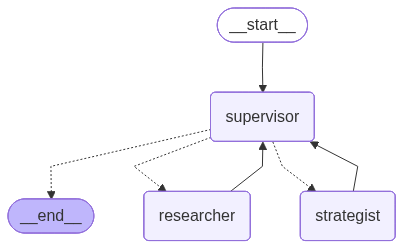

In [118]:
# Visualize your graph
supervisor

In [119]:
from IPython.display import Markdown, display

def print_stream(stream):
    for chunk in stream:
        for node, data in chunk.items():
            print(f"\n{'='*50}\nNode: {node}\n{'='*50}")
            
            if "messages" in data:
                # Get the last message in the chunk
                message = data["messages"][-1]
                
                # If it's an AI Message with content (the final answer)
                if hasattr(message, "content") and message.content:
                    display(Markdown(message.content))
                
                # If it's a Tool Call (showing the intent)
                if hasattr(message, "tool_calls") and message.tool_calls:
                    for tool in message.tool_calls:
                        print(f"🛠️  Calling Tool: {tool['name']} with args: {tool['args']}")
                
                # If it's a Tool Message (the result of the search)
                if node == "tools":
                    # Display the table properly
                    display(Markdown(message.content))

In [120]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

def pretty_print_messages(event):
    for node, data in event.items():
        print(f"\nUpdate from node {node}:\n")

        messages = data.get("messages", [])

        for msg in messages:

            # HUMAN MESSAGE
            if isinstance(msg, HumanMessage):
                print("="*32 + " Human Message " + "="*32)
                print(msg.content)

            # AI MESSAGE
            elif isinstance(msg, AIMessage):
                print("="*34 + " Ai Message " + "="*34)
                
                if msg.name:
                    print(f"Name: {msg.name}")

                if msg.tool_calls:
                    print("Tool Calls:")
                    for call in msg.tool_calls:
                        print(f"  {call['name']} ({call['id']})")
                        print(f"  Args: {call.get('args', {})}")
                elif msg.content:
                    print(msg.content)

            # TOOL MESSAGE
            elif isinstance(msg, ToolMessage):
                print("="*33 + " Tool Message " + "="*33)
                print(f"Name: {msg.name}")
                print("\n" + msg.content)

        print()


In [121]:
for chunk in supervisor.stream(
    {"messages": [{"role": "user", 
                   "content": "What players should I get in my fpl team for the upcoming gameweek? Provide logic about your strategy as well."}]}, 
                   config
):
    pretty_print_messages(chunk)

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.



Update from node supervisor:

================================ Human Message ================================
What players should I get in my fpl team for the upcoming gameweek? Provide logic about your strategy as well.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_researcher (call_71OEPYP0JZNjrNyn1WB51FyD)
  Args: {}
================================= Tool Message =================================
Name: transfer_to_researcher

Successfully transferred to researcher


Update from node researcher:

================================ Human Message ================================
What players should I get in my fpl team for the upcoming gameweek? Provide logic about your strategy as well.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_researcher (call_71OEPYP0JZNjrNyn1WB51FyD)
  Args: {}
================================= Tool Message ==

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.



Update from node supervisor:

================================ Human Message ================================
What players should I get in my fpl team for the upcoming gameweek? Provide logic about your strategy as well.
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_researcher (call_71OEPYP0JZNjrNyn1WB51FyD)
  Args: {}
================================= Tool Message =================================
Name: transfer_to_researcher

Successfully transferred to researcher
================================== Ai Message ==================================
Name: researcher
Tool Calls:
  current_gw_status (call_ySesBuTbOBuhH2dutgXZ0aEi)
  Args: {}
================================= Tool Message =================================
Name: current_gw_status

|    | status                                                                  | leagues   |
|---:|:-----------------------------------------------------------------------